### Importing requires libraries

In [1]:
pip install xgboost

     -------------------------------------- 125.4/125.4 MB 2.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\uttej\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [3]:
import numpy as np
import pandas as pd
import os
import re
import nltk
import string
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score
%matplotlib inline

### Reading csv into pandas dataframe

In [4]:
tweets = pd.read_csv('train.csv')
tweets.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
#Displaying a concise summary of the DataFrame
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
##Displaying number of rows and columns of the DataFrame
tweets.shape

(7613, 5)

#### Location wise values

In [6]:
tweets['location'].value_counts()

USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
MontrÌ©al, QuÌ©bec       1
Montreal                 1
ÌÏT: 6.4682,3.18287      1
Live4Heed??              1
Lincoln                  1
Name: location, Length: 3341, dtype: int64

#### Keywords count

In [7]:
tweets['keyword'].value_counts()

fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

### Data Cleaning

In [8]:
cols_to_drop = ['location','id']

In [9]:
tweets = tweets.drop(cols_to_drop, axis = 1)

In [10]:
tweets["CleanText"] = tweets["text"].apply(lambda x: x.lower())
tweets.head()

,keyword,text,target,CleanText
0,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this #earthquake m...
1,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask. canada
2,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to 'shelter in place' are ...
3,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or..."
4,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby #alaska as ...


In [11]:
tweets["CleanText"] = tweets["CleanText"].apply(lambda x: re.sub(r"https?://\S+|www\.\S+", "",x))

In [12]:
def removeHTML(text):
    html = re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")
    return re.sub(html, "", text)

tweets["CleanText"] = tweets["CleanText"].apply(lambda x: removeHTML(x))

In [13]:
def removeEmojis(text):
    emoji_pattern = re.compile("["
                       u"\U0001F600-\U0001F64F"  # emoticons
                       u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                       u"\U0001F680-\U0001F6FF"  # transport & map symbols
                       u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                       u"\U00002702-\U000027B0"
                       u"\U000024C2-\U0001F251"
                       u"\U0001f926-\U0001f937"
                       u"\u200d"
                       u"\u2640-\u2642" 
                       "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

tweets["CleanText"] = tweets["CleanText"].apply(lambda x: removeEmojis(x))

In [14]:
def RemovePunctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

In [15]:
tweets["CleanText"] = tweets["CleanText"].apply(lambda x: RemovePunctuation(x))

In [16]:
def RemoveASCII(text):
  return re.sub(r'[^\x00-\x7f]', "", text)

tweets["CleanText"] = tweets["CleanText"].apply(lambda x: RemoveASCII(x))

In [17]:
# def RemoveSpecial(text):
#     try:
#         return text.remove('#')
#     except:
#         return text

In [18]:
# tweets["CleanText"] = tweets["CleanText"].apply(lambda x: RemoveSpecial(x))

In [19]:
tweets.head(30)

,keyword,text,target,CleanText
0,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...
1,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...
3,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...
4,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...
5,NaN,#RockyFire Update => California Hwy. 20 closed...,1,rockyfire update california hwy 20 closed in ...
6,NaN,#flood #disaster Heavy rain causes flash flood...,1,flood disaster heavy rain causes flash floodin...
7,NaN,I'm on top of the hill and I can see a fire in...,1,im on top of the hill and i can see a fire in ...
8,NaN,There's an emergency evacuation happening now ...,1,theres an emergency evacuation happening now i...
9,NaN,I'm afraid that the tornado is coming to our a...,1,im afraid that the tornado is coming to our area


#### There are 61 missing values in Keyword feature

In [20]:
features = ['keyword']
for feat in features : 
    print("The number of missing values in "+ str(feat)+" are "+str(tweets[feat].isnull().sum()))

The number of missing values in keyword are 61


### Analysis

In [21]:
plot_size = plt.rcParams["figure.figsize"]
print(plot_size[0])
print(plot_size[1])

plot_size[0]=8
plot_size[1]=6
plt.rcParams["figure.figsize"]=plot_size


6.0
4.0


##### target = 1 is when disaster occurs and target = 0 is when disaster does not occur

c:\Users\uttej\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'samples')

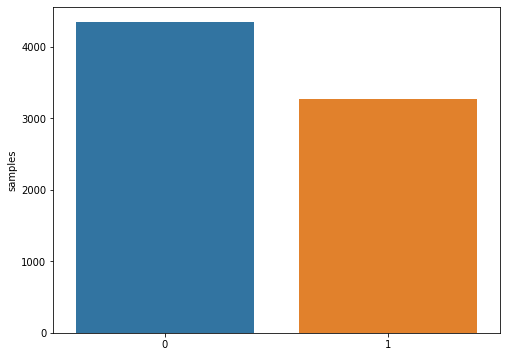

In [22]:
x=tweets.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')

In [23]:
def _corpus(target):
    corpus=[] # document
    
    for x in tweets[tweets['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

<BarContainer object of 20 artists>

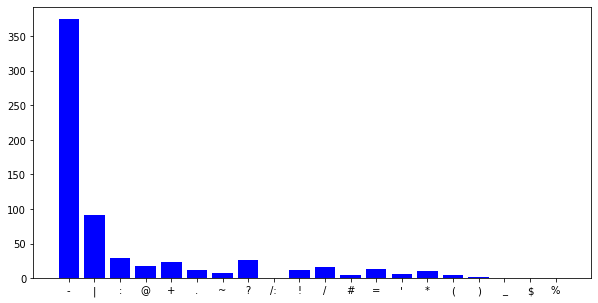

In [24]:
from collections import defaultdict
plt.figure(figsize=(10,5))
corpus=_corpus(0)
import string
d=defaultdict(int)
s = string.punctuation
for i in (corpus):
    if i in s:
        d[i]+=1
        
x,y=zip(*d.items())
plt.bar(x,y,color='blue')

In [25]:
# Observing the stop words like a, the, in, is etc
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))

In [26]:
from collections import  Counter
c=Counter(corpus)
m=c.most_common()
x=[]
y=[]
for w,c in m[:]:
    if (w not in stop):
        x.append(w)
        y.append(c)

#sns.barplot(x=y,y=x)

Tokenize CleanText

In [32]:
tweets['TokenizedText'] = tweets['CleanText'].apply(nltk.word_tokenize)

display(tweets.head())

,keyword,text,target,CleanText,TokenizedText
0,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...,"[our, deeds, are, the, reason, of, this, earth..."
1,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]"
2,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,"[all, residents, asked, to, shelter, in, place..."
3,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation..."
4,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...,"[just, got, sent, this, photo, from, ruby, ala..."


Remove stopwords

In [33]:
tweets['RemoveStopWords'] = tweets['TokenizedText'].apply(lambda x: [word for word in x if word not in stop])
tweets.head()

,keyword,text,target,CleanText,TokenizedText,RemoveStopWords
0,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...,"[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv..."
1,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]"
2,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,"[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o..."
3,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation..."
4,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...,"[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi..."


Stemming

In [34]:
def doPorterStemmer(text):
    stemmer = nltk.PorterStemmer()
    stems = [stemmer.stem(i) for i in text]
    return stems

tweets['PorterStemmer'] = tweets['RemoveStopWords'].apply(lambda x: doPorterStemmer(x))
tweets.head()

,keyword,text,target,CleanText,TokenizedText,RemoveStopWords,PorterStemmer
0,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...,"[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...","[deed, reason, earthquak, may, allah, forgiv, us]"
1,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, rong, sask, canada]"
2,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,"[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...","[resid, ask, shelter, place, notifi, offic, ev..."
3,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[13000, peopl, receiv, wildfir, evacu, order, ..."
4,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...,"[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...","[got, sent, photo, rubi, alaska, smoke, wildfi..."


Lemmatization

In [36]:
from nltk.stem import WordNetLemmatizer

def doLemmatizeWord(text):
    lemmatizer = WordNetLemmatizer()
    lemma = [lemmatizer.lemmatize(word) for word in text]
    return lemma

tweets['LemmatizedText'] = tweets['RemoveStopWords'].apply(lambda x: doLemmatizeWord(x))
tweets.head()

,keyword,text,target,CleanText,TokenizedText,RemoveStopWords,PorterStemmer,LemmatizedText
0,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...,"[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...","[deed, reason, earthquak, may, allah, forgiv, us]","[deed, reason, earthquake, may, allah, forgive..."
1,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, rong, sask, canada]","[forest, fire, near, la, ronge, sask, canada]"
2,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,"[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...","[resid, ask, shelter, place, notifi, offic, ev...","[resident, asked, shelter, place, notified, of..."
3,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[13000, peopl, receiv, wildfir, evacu, order, ...","[13000, people, receive, wildfire, evacuation,..."
4,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...,"[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...","[got, sent, photo, rubi, alaska, smoke, wildfi...","[got, sent, photo, ruby, alaska, smoke, wildfi..."


In [38]:
# Using WordNetLemmatizer for FINAL text
tweets['FINAL']=tweets['LemmatizedText'].apply(lambda x: ''.join(i+' ' for i in x))
tweets.head()

,keyword,text,target,CleanText,TokenizedText,RemoveStopWords,PorterStemmer,LemmatizedText,FINAL
0,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...,"[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...","[deed, reason, earthquak, may, allah, forgiv, us]","[deed, reason, earthquake, may, allah, forgive...",deed reason earthquake may allah forgive u
1,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, rong, sask, canada]","[forest, fire, near, la, ronge, sask, canada]",forest fire near la ronge sask canada
2,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,"[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...","[resid, ask, shelter, place, notifi, offic, ev...","[resident, asked, shelter, place, notified, of...",resident asked shelter place notified officer ...
3,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[13000, peopl, receiv, wildfir, evacu, order, ...","[13000, people, receive, wildfire, evacuation,...",13000 people receive wildfire evacuation order...
4,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...,"[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...","[got, sent, photo, rubi, alaska, smoke, wildfi...","[got, sent, photo, ruby, alaska, smoke, wildfi...",got sent photo ruby alaska smoke wildfire pour...


Converting Text into Numeric format using different approaches

In [39]:
# 1. CounterVector Numerical Dataset
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
cv_df = vectorizer.fit_transform(tweets['FINAL'])

vectorizer.get_feature_names_out()

array(['0011', '001116', '0025', ..., 'zurich', 'zxathetis', 'zzzz'],
      dtype=object)

In [40]:
# 2. Numerical Dataset using TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

tfvectorizer = TfidfVectorizer(ngram_range = (1,2))
tfidf_df = tfvectorizer.fit_transform(tweets['FINAL'])

In [49]:
# 3. Numerical Dataset using Word2Vec
from gensim.models import Word2Vec, KeyedVectors
import multiprocessing

sentences = tweets['FINAL'].values
sentences = [nltk.word_tokenize(sent) for sent in sentences]

w2v_size = 300

cores = multiprocessing.cpu_count() # Count the number of cores in a computer

w2v_model = Word2Vec(
  min_count=1,
  window=2,
  vector_size=w2v_size,
  sample=6e-5, 
  alpha=0.03, 
  min_alpha=0.0007, 
  negative=20,
  workers=cores-1
  )

w2v_model.build_vocab(sentences, progress_per=10000)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

words = list(w2v_model.wv.key_to_index)
w2v_df = []
for sent in sentences:
    vw = np.zeros(w2v_size) 
    #one sentence has many words
    for word in sent:
        vw +=  w2v_model.wv[word]
    #average
    vw = vw/len(sent)
    w2v_df.append(np.array(vw))

In [51]:
# 4. Reduce Dimension with Principal Component Analysis
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

trans_w2v_df = StandardScaler().fit_transform(w2v_df)

#reduce dimention half
pca = PCA(n_components=100)
pca_trans_w2v_df = pca.fit_transform(trans_w2v_df)

Data Split

In [53]:
RANDOM_STATE = 2022
TEST_SIZE = 0.3

cv_train_X, cv_test_X, cv_train_Y, cv_test_y = train_test_split(cv_df, tweets['target'], test_size=TEST_SIZE, random_state=RANDOM_STATE)
tfidf_train_X, tfidf_test_X, tfidf_train_Y, tfidf_test_y = train_test_split(tfidf_df, tweets['target'], test_size=TEST_SIZE, random_state=RANDOM_STATE)
w2v_train_X, w2v_test_X, w2v_train_Y, w2v_test_y = train_test_split(w2v_df, tweets['target'], test_size=TEST_SIZE, random_state=RANDOM_STATE)
pca_w2v_train_X, pca_w2v_test_X, pca_w2v_train_Y, pca_w2v_test_y = train_test_split(pca_trans_w2v_df, tweets['target'], test_size=TEST_SIZE, random_state=RANDOM_STATE)

Random Forest

In [60]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def model_RandomForest(train_X, test_X, train_y, test_y):
  rf = RandomForestClassifier()
  rf_model = rf.fit(train_X, train_y.values.ravel())
  pred_y = rf_model.predict(test_X)

  #Accuracy
  print('accuracy_score: %.3f' % accuracy_score(test_y, pred_y))
  print('Recall: %.3f' % recall_score(test_y, pred_y))
  print('Precision: %.3f' % precision_score(test_y, pred_y))
  print('F1 Score: %.3f' % f1_score(test_y, pred_y))

In [62]:
print ('---------------------- RANDOM FOREST | DATASET: COUNTER-VECTOR ----------------------')
model_RandomForest(cv_train_X, cv_test_X, cv_train_Y, cv_test_y)
print ('---------------------- RANDOM FOREST | DATASET: TF-IDF ----------------------')
model_RandomForest(tfidf_train_X, tfidf_test_X, tfidf_train_Y, tfidf_test_y)
print ('---------------------- RANDOM FOREST | DATASET: WORD2VEC ----------------------')
model_RandomForest(w2v_train_X, w2v_test_X, w2v_train_Y, w2v_test_y)
print ('---------------------- RANDOM FOREST | DATASET: WORD2VEC with PCA ----------------------')
model_RandomForest(pca_w2v_train_X, pca_w2v_test_X, pca_w2v_train_Y, pca_w2v_test_y)

---------------------- RANDOM FOREST | DATASET: COUNTER-VECTOR ----------------------
accuracy_score: 0.788
Recall: 0.668
Precision: 0.813
F1 Score: 0.733
---------------------- RANDOM FOREST | DATASET: TF-IDF ----------------------
accuracy_score: 0.773
Recall: 0.573
Precision: 0.859
F1 Score: 0.688
---------------------- RANDOM FOREST | DATASET: WORD2VEC ----------------------
accuracy_score: 0.747
Recall: 0.594
Precision: 0.774
F1 Score: 0.672
---------------------- RANDOM FOREST | DATASET: WORD2VEC with PCA ----------------------
accuracy_score: 0.767
Recall: 0.637
Precision: 0.788
F1 Score: 0.704


##### Random Forest with Counter Vector has the best accuracy: 0.788

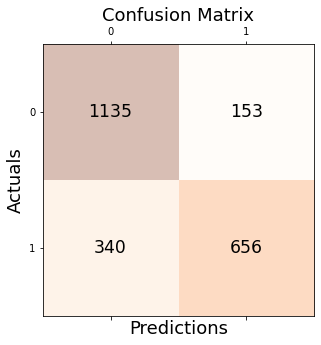

In [66]:
from sklearn.metrics import confusion_matrix

rf = RandomForestClassifier()
rf_model = rf.fit(cv_train_X, cv_train_Y.values.ravel())
pred_y = rf_model.predict(cv_test_X)

conf_matrix = confusion_matrix(y_true=cv_test_y, y_pred=pred_y)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

##### XG-BOOST

In [63]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

def model_XGBoost(train_X, test_X, train_y, test_y):
  xgb_cl = xgb.XGBClassifier()
  xg_model = xgb_cl.fit(train_X, train_y.values.ravel())
  pred_y = xg_model.predict(test_X)

  #Accuracy
  print('accuracy_score: %.3f' % accuracy_score(test_y, pred_y))
  print('Recall: %.3f' % recall_score(test_y, pred_y))
  print('Precision: %.3f' % precision_score(test_y, pred_y))
  print('F1 Score: %.3f' % f1_score(test_y, pred_y))

In [64]:
print ('---------------------- XGBOOST | DATASET: COUNTER-VECTOR ----------------------')
model_XGBoost(cv_train_X, cv_test_X, cv_train_Y, cv_test_y)
print ('---------------------- XGBOOST | DATASET: TF-IDF ----------------------')
model_XGBoost(tfidf_train_X, tfidf_test_X, tfidf_train_Y, tfidf_test_y)
print ('---------------------- XGBOOST | DATASET: WORD2VEC ----------------------')
model_XGBoost(w2v_train_X, w2v_test_X, w2v_train_Y, w2v_test_y)
print ('---------------------- XGBOOST | DATASET: WORD2VEC with PCA ----------------------')
model_XGBoost(pca_w2v_train_X, pca_w2v_test_X, pca_w2v_train_Y, pca_w2v_test_y)

---------------------- XGBOOST | DATASET: COUNTER-VECTOR ----------------------
accuracy_score: 0.773
Recall: 0.618
Precision: 0.817
F1 Score: 0.704
---------------------- XGBOOST | DATASET: TF-IDF ----------------------
accuracy_score: 0.765
Recall: 0.615
Precision: 0.799
F1 Score: 0.695
---------------------- XGBOOST | DATASET: WORD2VEC ----------------------
accuracy_score: 0.745
Recall: 0.641
Precision: 0.740
F1 Score: 0.687
---------------------- XGBOOST | DATASET: WORD2VEC with PCA ----------------------
accuracy_score: 0.768
Recall: 0.660
Precision: 0.776
F1 Score: 0.713


##### XGBoost with Counter Vector has the best accuracy: 0.773

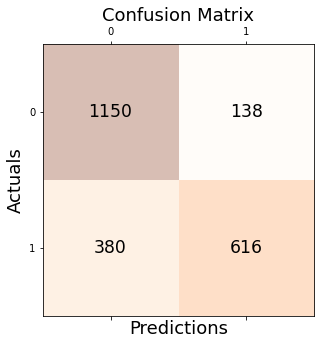

In [67]:
xgb_cl = xgb.XGBClassifier()
xg_model = xgb_cl.fit(cv_train_X, cv_train_Y.values.ravel())
pred_y = xg_model.predict(cv_test_X)

conf_matrix = confusion_matrix(y_true=cv_test_y, y_pred=pred_y)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()